# Recurrent neural networks for time series regression with TensorFlow Eager
----

Hello everyone! In this tutorial, we are going to explore how we can build a recurrent neural network for time series regression. As my background is in power systems I thought it will only be fair to include at least a tutorial related to this field. Thus, in this tutorial we are going to build an RNN for energy demand forecasting.

To predict the next-day energy demand, we will work with the hourly energy consumption data provided by [ENTSO-E](https://transparency.entsoe.eu/). I've chosen to work with data from Spain as I am currently living here. Nevertheless, the same analysis can be applied to energy consumption data belonging from any country.

### Tutorial steps
----
![img](tutorials_graphics/05_flowchart.png)

* *Exploratory data analysis on energy demand data from ENTSO-E*
* *Create a train and test dataset*
* *Process raw data to create input and target samples*
* *Create RNN class for regression*
    * *Train model with gradient descent either from scratch or from previous checkpoint*
* *Visualize the difference between forecasted and actual values on the test dataset*
    
If you would like to add anything to this tutorial please let me know. Also, I am happy to hear any suggestions you have for improvement.

## Import here useful libraries
----

In [2]:
# Import TensorFlow and TensorFlow Eager
import tensorflow.contrib.eager as tfe
import tensorflow as tf

# Import libraries for data processing
from sklearn.preprocessing import StandardScaler
from datetime import datetime as dt
import pandas as pd
import numpy as np

# Import library for plotting
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Enable eager mode. Once activated it cannot be reversed! Run just once.
tfe.enable_eager_execution(device_policy=tfe.DEVICE_PLACEMENT_SILENT)

## Exploratory data analysis
----

The dataset used in this tutorial can be found in the folder *datasets/load_forecasting*. Let's read it and have a look at it!

In [4]:
energy_df = pd.read_csv('datasets/load_forecasting/spain_hourly_entsoe.csv')
energy_df.tail(2)

,Time (CET),Day-ahead Total Load Forecast [MW] - BZN|ES,Actual Total Load [MW] - BZN|ES
29230,02.05.2018 22:00 - 02.05.2018 23:00,30187.0,30344.0
29231,02.05.2018 23:00 - 03.05.2018 00:00,27618.0,27598.0


In [5]:
# Rename columns
energy_df.columns = ['time', 'forecasted_load', 'actual_load']

In [6]:
# Extract the date and hour from 'Time (CET)'
energy_df['date'] = energy_df['time'].apply(lambda x: dt.strptime(x.split('-')[0].strip(), '%d.%m.%Y %H:%M'))

As you can see, the dataset comes with the timestamp of each measurement, the actual energy demand for a particular hour, as long with its forecasted value. For our task, we will only use the **'Actual Total Load [MW]'** column.

In [7]:
print('The date of the first measurement: ', energy_df.loc[0, 'time'])

The date of the first measurement:  01.01.2015 00:00 - 01.01.2015 01:00


In [8]:
print('The date of the last measurement: ', energy_df.loc[len(energy_df)-1, 'time'])

The date of the last measurement:  02.05.2018 23:00 - 03.05.2018 00:00


The dataset is comprised of hourly energy consumption data starting from 1st January 2015 until 2nd of May 2018. Quite recent data :)!

## Create input and target samples from time series data
----

### Split data in train/test datasets
----
The first step in data processing is to create a train and test dataset from the original data. I have chosen to keep 80% of the data in the train and 20% in the test. Feel free to play with this parameter by nudging the train_size variable.

In [9]:
# Split dataset into train and test
train_size = 0.8
end_train = int(len(energy_df)*train_size/24)*24
train_energy_df = energy_df.iloc[:end_train,:]
test_energy_df = energy_df.iloc[end_train:,:]

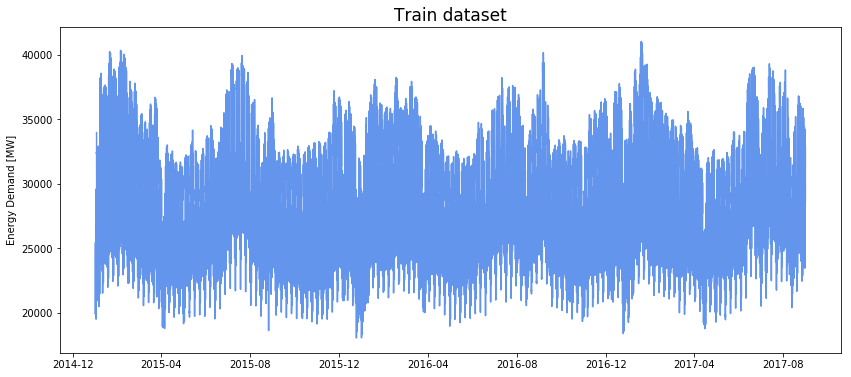

In [10]:
# Plot train dataset 
plt.figure(figsize=(14,6))
plt.plot(train_energy_df['date'], train_energy_df['actual_load'], color='cornflowerblue');
plt.title('Train dataset', fontsize=17);
plt.ylabel('Energy Demand [MW]');

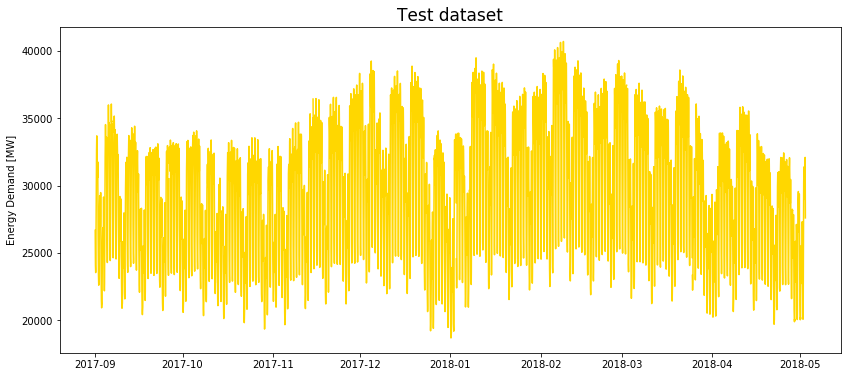

In [11]:
# Plot test dataset 
plt.figure(figsize=(14,6))
plt.plot(test_energy_df['date'], test_energy_df['actual_load'], color='gold');
plt.title('Test dataset', fontsize=17);
plt.ylabel('Energy Demand [MW]');

### Scale dataset
----
Neural networks work better and converge much faster is the data is normalized. For this task, I have chosen to normalize the data with zero mean and unit variance as I find that this works better with LSTM. You can also try to normalize the data using a MinMaxScaler and see if you can obtain better results.

In [12]:
# Interpolate missing measurements
train_energy_df = train_energy_df.interpolate(limit_direction='both')
test_energy_df = test_energy_df.interpolate(limit_direction='both')

In [13]:
scaler = StandardScaler().fit(train_energy_df['actual_load'][:,None])
train_energy_df['actual_load'] = scaler.transform(train_energy_df['actual_load'][:,None])
test_energy_df['actual_load'] = scaler.transform(test_energy_df['actual_load'][:,None])

### Create moving window samples
----
You can find in the code cell below the function that I have created to produce input and target samples from a timeseries data. The input in each RNN cell is the hourly profile of one day. The number of timesteps is defined by the *look_back* variable, which specifies how many days to look back. The default is 5 days, which means that the RNN will unroll for 5 steps.

You can also specify how many days to predict ahead, the default being one day.

The input and target samples are created based on the *look_back* and *predict_ahead* variables, as it can be seen in the figure below.

![img](tutorials_graphics/moving_windows_samples.png)

In [14]:
def moving_window_samples(timeseries, look_back=5, predict_ahead=1):
    '''
    Function to create input and target samples from a time-series 
    using a lag of one day.
    
    Args:
        timeseries: timeseries dataset.
        look_back: the size of the input. Specifies how many days to look back.
        predict_ahead: size of the output. Specifies how many days to predict ahead.
    
    Returns:
        input_samples: the input samples createad from the timeseries, 
                       using a window shift of one day.
        target_samples: the target corresponding to each input sample.
    '''
    
    n_strides = int((len(timeseries)- predict_ahead*24 - look_back*24 + 24)/24)
    input_samples = np.zeros((n_strides, look_back*24))
    target_samples = np.zeros((n_strides, predict_ahead*24))
    for i in range(n_strides):
        end_input = i*24 + look_back*24
        input_samples[i,:] = timeseries[i*24:end_input]
        target_samples[i,:] = timeseries[end_input:(end_input + predict_ahead*24)]  
        
    # Reshape input to (num_samples, timesteps, input_dimension)
    input_samples = input_samples.reshape((-1, look_back, 24))
    return input_samples.astype('float32'), target_samples.astype('float32')

In [15]:
train_input_samples, train_target_samples = moving_window_samples(train_energy_df['actual_load'],
                                                                  look_back=5, predict_ahead=1)

In [16]:
test_input_samples, test_target_samples = moving_window_samples(test_energy_df['actual_load'],
                                                                look_back=5, predict_ahead=1)

### Create train and test dataset with tf.data.Dataset 
----
As usually, we transfer the data to tensors using the tf.data.Dataset API. I've chosen a batch size of 64 but feel free to play with it. We can iterate very easily through these datasets with the tfe.Iterator function, when training the network.

In [17]:
# Feel free to modify the size of the batches
# Usually smaller batch sizes obtain better results on test data
batch_size = 64
train_dataset = (tf.data.Dataset.from_tensor_slices(
    (train_input_samples, train_target_samples)).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(
    (test_input_samples, test_target_samples)).batch(batch_size))

## RNN model for regression compatible with Eager API
----

The class of the RNN model is very similar to the previous models. During initialization, we define all the layers needed in the forward pass. We can also specify the device where you would like to perform the computations on, as well as the filepath where we would like either to restore or save the variables of the model. The model inherits from tf.keras.Model in order to keep track of all of our variables. 

The architecture for this model is very simple. We simply take the hourly profile of the last *look_back* days, and pass them through the RNN, one step at a time. The final output is passed through a dense layer with a ReLU activation. The output layer size is defined by the *predict_ahead* variable. In our case, the output size is 24 units, as we are predicting the energy demand for the next day. 
![img](tutorials_graphics/rnn_regression.png)

In [18]:
class RegressionRNN(tf.keras.Model):
    def __init__(self, cell_size=64, dense_size=128, predict_ahead=1, 
                 device='cpu:0', checkpoint_directory=None):
        ''' Define the parameterized layers used during forward-pass, the device
            where you would like to run the computation on and the checkpoint
            directory. Additionaly, you can also modify the default size of the 
            network.
            
            Args:
                cell_size: RNN cell size.
                dense_size: the size of the dense layer.
                predict_ahead: the number of days you would like to predict ahead.
                device: string, 'cpu:n' or 'gpu:n' (n can vary). Default, 'cpu:0'.
                checkpoint_directory: the directory where you would like to 
                                      save/restore a model.
        '''
        super(RegressionRNN, self).__init__()
        
        # Weights initializer function
        w_initializer = tf.contrib.layers.xavier_initializer()
    
        # Biases initializer function
        b_initializer = tf.zeros_initializer()
        
        # Dense layer initialization
        self.dense_layer = tf.keras.layers.Dense(dense_size, activation=tf.nn.relu, 
                                                 kernel_initializer=w_initializer, 
                                                 bias_initializer=b_initializer)
        
        # Predictions layer initialization
        self.pred_layer = tf.keras.layers.Dense(predict_ahead*24, activation=None, 
                                                kernel_initializer=w_initializer, 
                                                bias_initializer=b_initializer)
        
        # Basic LSTM cell
        self.rnn_cell = tf.nn.rnn_cell.BasicLSTMCell(cell_size)
        
        # Define the device 
        self.device = device
        
        # Define the checkpoint directory
        self.checkpoint_directory = checkpoint_directory
        
    def predict(self, X):
        '''
        Performs a forward-pass through the network.

        Args:
            X: 3D tensor of shape (batch_size, timesteps, input_dimension).
        
        Returns:
            preds: the final predictions of the network.
        '''
        
        # Get the number of samples within a batch
        num_samples = tf.shape(X)[0]

        # Initialize LSTM cell state with zeros
        state = self.rnn_cell.zero_state(num_samples, dtype=tf.float32)
        
        # Unstack the input
        unstacked_input = tf.unstack(X, axis=1)
        
        # Iterate through each timestep 
        for input_step in unstacked_input:
            output, state = self.rnn_cell(input_step, state)
        
        # Pass the last cell state through a dense layer (ReLU activation)
        dense = self.dense_layer(output)
        
        # Compute the final predictions
        preds = self.pred_layer(dense)
        return preds
    
    def loss_fn(self, X, y):
        """ Defines the loss function used during 
            training.         
        """
        preds = self.predict(X)
        loss = tf.losses.mean_squared_error(y, preds)
        return loss
    
    def grads_fn(self, X, y):
        """ Dynamically computes the gradients of the loss value
            with respect to the parameters of the model, in each
            forward pass.
        """
        with tfe.GradientTape() as tape:
            loss = self.loss_fn(X, y)
        return tape.gradient(loss, self.variables)
    
    def restore_model(self):
        """ Function to restore trained model.
        """
        with tf.device(self.device):
            # Run the model once to initialize variables
            dummy_input = tf.constant(tf.zeros((1, 5, 24)))
            dummy_pred = self.predict(dummy_input)
            # Restore the variables of the model
            saver = tfe.Saver(self.variables)
            saver.restore(tf.train.latest_checkpoint
                          (self.checkpoint_directory))
    
    def save_model(self, global_step=0):
        """ Function to save trained model.
        """
        tfe.Saver(self.variables).save(self.checkpoint_directory, 
                                       global_step=global_step)   
        
    def fit(self, training_data, eval_data, optimizer, num_epochs=500, 
            early_stopping_rounds=10, verbose=10, train_from_scratch=False):
        """ Function to train the model, using the selected optimizer and
            for the desired number of epochs. You can either train from scratch
            or load the latest model trained. Early stopping is used in order to
            mitigate the risk of overfitting the network.
            
            Args:
                training_data: the data you would like to train the model on.
                                Must be in the tf.data.Dataset format.
                eval_data: the data you would like to evaluate the model on.
                            Must be in the tf.data.Dataset format.
                optimizer: the optimizer used during training.
                num_epochs: the maximum number of iterations you would like to 
                            train the model.
                early_stopping_rounds: stop training if the loss on the eval 
                                       dataset does not decrease after n epochs.
                verbose: int. Specify how often to print the loss value of the network.
                train_from_scratch: boolean. Whether to initialize variables of the
                                    the last trained model or initialize them
                                    randomly.
        """ 
    
        if train_from_scratch==False:
            self.restore_model()
        
        # Initialize best loss. This variable will store the lowest loss on the
        # eval dataset.
        best_loss = 999
        
        # Initialize classes to update the mean loss of train and eval
        train_loss = tfe.metrics.Mean('train_loss')
        eval_loss = tfe.metrics.Mean('eval_loss')
        
        # Initialize dictionary to store the loss history
        self.history = {}
        self.history['train_loss'] = []
        self.history['eval_loss'] = []
        
        # Begin training
        with tf.device(self.device):
            for i in range(num_epochs):
                # Training with gradient descent
                for X, y in tfe.Iterator(training_data):
                    grads = self.grads_fn(X, y)
                    optimizer.apply_gradients(zip(grads, self.variables))
                    
                # Compute the loss on the training data after one epoch
                for X, y in tfe.Iterator(training_data):
                    loss = self.loss_fn(X, y)
                    train_loss(loss)
                self.history['train_loss'].append(train_loss.result().numpy())
                # Reset metrics
                train_loss.init_variables()
                
                # Compute the loss on the eval data after one epoch
                for X, y in tfe.Iterator(eval_data):
                    loss = self.loss_fn(X, y)
                    eval_loss(loss)
                self.history['eval_loss'].append(eval_loss.result().numpy())
                # Reset metrics
                eval_loss.init_variables()
                
                # Print train and eval losses
                if (i==0) | ((i+1)%verbose==0):
                    print('Train loss at epoch %d: ' %(i+1), self.history['train_loss'][-1])
                    print('Eval loss at epoch %d: ' %(i+1), self.history['eval_loss'][-1])

                # Check for early stopping
                if self.history['eval_loss'][-1]<best_loss:
                    best_loss = self.history['eval_loss'][-1]
                    count = early_stopping_rounds
                else:
                    count -= 1
                if count==0:
                    break  

## Train the model with gradient descent
----

In [51]:
# Specify the path where you want to save/restore the trained variables.
checkpoint_directory = 'models_checkpoints/DemandRNN/'

# Use the GPU if available.
device = 'gpu:0' if tfe.num_gpus()>0 else 'cpu:0'

# Define optimizer.
optimizer = tf.train.AdamOptimizer(learning_rate=1e-2)

# Instantiate model. This doesn't initialize the variables yet.
model = RegressionRNN(cell_size=16, dense_size=16, predict_ahead=1, 
                      device=device, checkpoint_directory=checkpoint_directory)

In [52]:
# Train model
model.fit(train_dataset, test_dataset, optimizer, num_epochs=500, 
          early_stopping_rounds=5, verbose=50, train_from_scratch=True)

Train loss at epoch 1:  0.5420932229608297
Eval loss at epoch 1:  0.609554298222065
Train loss at epoch 50:  0.024180740118026733
Eval loss at epoch 50:  0.049175919964909554


In [53]:
# Save model
model.save_model()

## Visualize the performance during training

We can easily visualize the loss history as it was tracked automaticaly during model fitting.

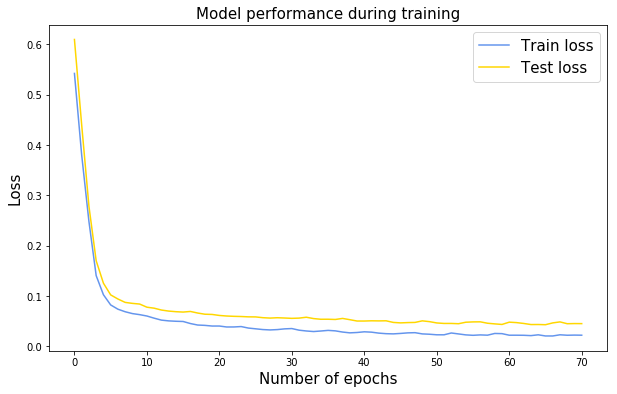

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(model.history['train_loss'])), model.history['train_loss'],
         color='cornflowerblue', label='Train loss');
plt.plot(range(len(model.history['eval_loss'])), model.history['eval_loss'], 
         color='gold', label='Test loss');
plt.title('Model performance during training', fontsize=15)
plt.xlabel('Number of epochs', fontsize=15);
plt.ylabel('Loss', fontsize=15);
plt.legend(fontsize=15);

## Visualize predictions on the test dataset
----

This is the final part of the tutorial. After training the network, we can visualize the forecasts made on the test dataset.

If you have skipped the training, I have added a cell where you can easily restore an already trained model.

In [55]:
##################################################
# Restore previously trained model
##################################################
tf.reset_default_graph()
checkpoint_directory = 'models_checkpoints/DemandRNN/'
model = RegressionRNN(cell_size=16, dense_size=16, predict_ahead=1, 
                      device=device, checkpoint_directory=checkpoint_directory)
model.restore_model()

INFO:tensorflow:Restoring parameters from models_checkpoints/DemandRNN/-0


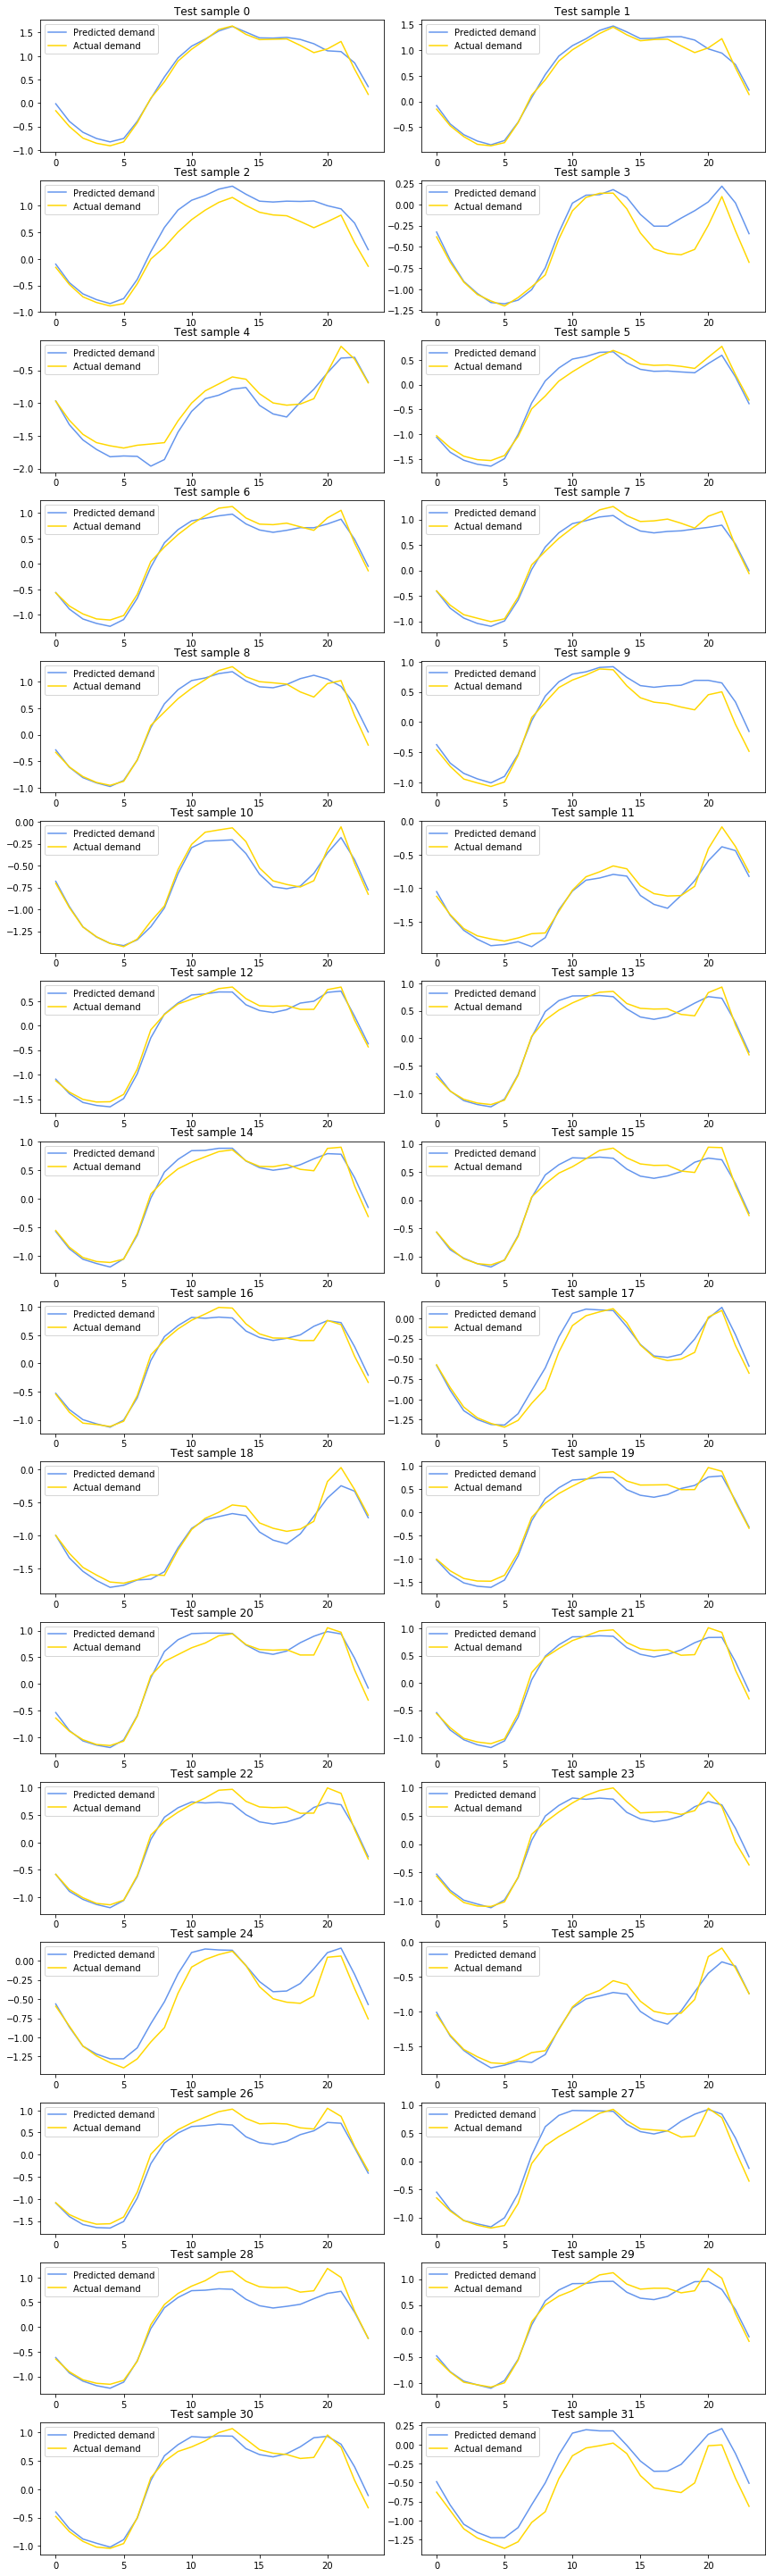

In [56]:
###################################################
# Visualize actual values vs forecasted values
###################################################
with tf.device(device):
    # Create iterator for input and target test samples
    X_test, y_test = tfe.Iterator(test_dataset).next()
    # Predict on test batch
    preds = model.predict(X_test).numpy()
    y = y_test.numpy()
    # Create subplots for half of the batch samples (32)
    f, axarr = plt.subplots(16, 2, figsize=(12, 40))
    f.tight_layout()
    # Plot predictions
    i, j = 0, 0
    for idx in range(32):
        axarr[i,j].plot(range(24), preds[idx,:], label='Predicted demand', 
                        color='cornflowerblue')
        axarr[i,j].plot(range(24), y[idx,:], label='Actual demand',
                        color='gold')
        axarr[i,j].legend()
        axarr[i,j].set_title('Test sample %d' %idx)
        if j==1:
            i += 1
            j = 0
        else:
            j += 1